# 1. 加载数据

In [8]:
import torch
import numpy as np
import random

import imageio
import matplotlib.pyplot as plt

name0 = ["lena"]
name = ["lena_mar"]
image = imageio.imread('./datasets/{}.bmp'.format(name0[0]))
sparse_image = imageio.imread('./datasets/{}.bmp'.format(name[0]))
sparse_mat = sparse_image[:, :, 1]
dense_mat = image[:, :, 1]

raw_nan_index = list(set([random.randint(0, 255) for i in range(20)]))
sparse_mat[raw_nan_index, :] = 0.

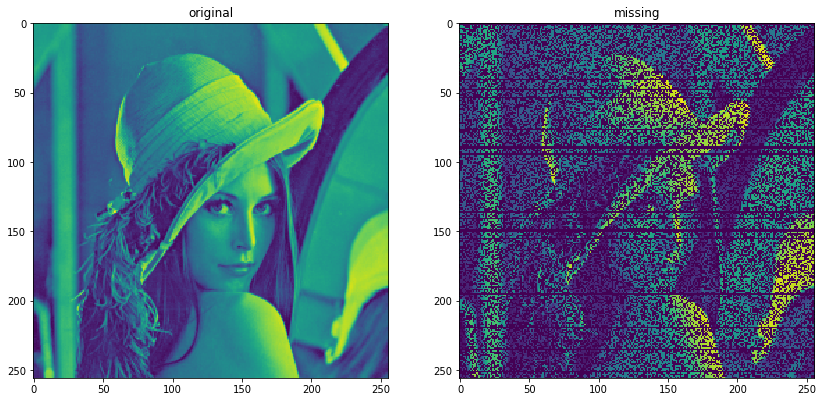

In [9]:
def PlotImages(*params):
    if len(params) == 2: 
        fig = plt.figure(figsize=(14,7))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        ax1.imshow(params[0])
        ax1.set_title('original')
        
        ax2.imshow(params[1])
        ax2.set_title('missing')
    
    elif len(params) == 3:
        fig = plt.figure(figsize=(21, 7))
        ax1 = fig.add_subplot(131)
        ax2 = fig.add_subplot(132)
        ax3 = fig.add_subplot(133)
        
        ax1.imshow(params[0])
        ax1.set_title('original')
        
        ax2.imshow(params[1])
        ax2.set_title('missing')
        
        ax3.imshow(params[2])
        ax3.set_title('prediction')
# ========================================

def Measurement(original, prediction, missing_index):
    pred_error = original-prediction
    pred_error = pred_error[missing_index]
    ae = np.abs(pred_error)
    mae = np.mean(ae)
    mse = np.mean(ae*ae)
    print('mae:{0:.4f}, mse:{1:.4f}'.format(mae, mse))
    return mae, mse
# ========================================
PlotImages(dense_mat, sparse_mat)

# 2. Low-Rank Matrix Factorization 
基于梯度下降法的，低秩矩阵分解补全

## 2.0. 基本参数设置

In [10]:
K       = 20
epoches = 1000
verbose = 50
lr      = 0.2
beta    = 0.001  # 正则化系数

missing_value  = 0. # 缺失值标记

device = torch.device('cpu')
dtype  = torch.float

missing_matrix = torch.tensor(sparse_mat.copy(), dtype = dtype)
# 缺失值索引
missing_index  = np.where(missing_matrix == missing_value)
# 未缺失值索引
complete_index = np.where(missing_matrix != missing_value)
# print(complete_index[0].shape, missing_index[0].shape)

M = missing_matrix.shape[0]
N = missing_matrix.shape[1]

In [34]:
def PlotLosses(all_losses):
    fig = plt.figure(figsize=(18, 5))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)

    ax1.plot([i[0] for i in all_losses])
    ax1.set_title('all losses')

    ax2.plot([i[1] for i in all_losses])
    ax2.set_title('loss')

    ax3.plot([i[2] for i in all_losses])
    ax3.set_title('regular')

## 2.1. 方法一

### 2.1.1. 训练过程

In [35]:
# 初始化参数
U   = torch.randn(M, K, device=device, dtype=dtype, requires_grad=True)
V   = torch.randn(N, K, device=device, dtype=dtype, requires_grad=True)
U_b = torch.randn(M, 1, device=device, dtype=dtype, requires_grad=True)
V_b = torch.randn(1, N, device=device, dtype=dtype, requires_grad=True)

all_losses = []
# 训练
for epoch in range(1, epoches+1):
    # 预测值
    pred_matrix = torch.mm(U, V.T) + U_b + V_b
    # 损失函数
    error = missing_matrix - pred_matrix
    loss  = torch.mean(error[complete_index] * error[complete_index])
    # 正则化系数
    regular = beta / 2 + torch.norm(U, p='fro') + torch.norm(U_b, p='fro') \
                       + torch.norm(V, p='fro') + torch.norm(V_b, p='fro')
    
    all_loss = loss + regular
    
    all_losses.append([all_loss, loss, regular])
    if epoch % verbose == 0:
        print(epoch, loss.item())

    # Use autograd to compute the backward pass.
    all_loss.backward()
    # Update weights using gradient descent
    with torch.no_grad():
        U -= lr * U.grad
        V -= lr * V.grad
        U_b -= lr * U_b.grad
        V_b -= lr * V_b.grad

        U.grad.zero_()
        V.grad.zero_()
        U_b.grad.zero_()
        V_b.grad.zero_()

50 1888.2955322265625
100 1293.890380859375
150 816.7418212890625
200 599.8909301757812
250 468.8372497558594
300 383.8769226074219
350 330.189697265625
400 294.13690185546875
450 268.365966796875
500 248.95033264160156
550 233.8260955810547
600 221.85299682617188
650 212.25880432128906
700 204.45155334472656
750 198.14854431152344
800 192.9563751220703
850 188.6168975830078
900 185.04896545410156
950 181.99496459960938
1000 179.44708251953125


### 2.1.2. 结果评价

mae:13.1560, mse:373.2945


(13.156001, 373.29453)

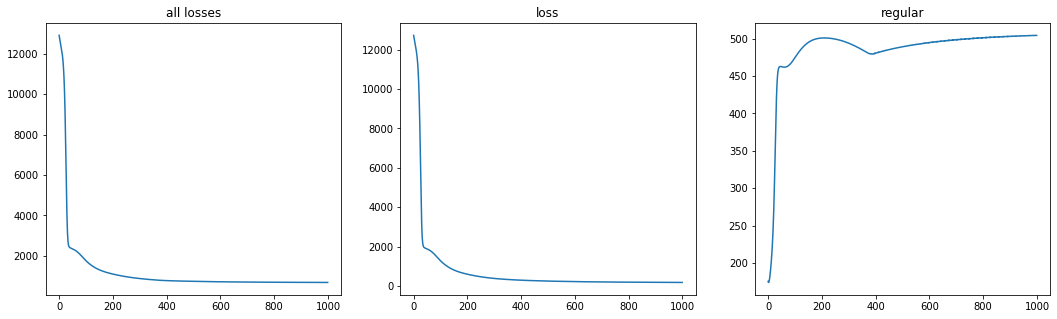

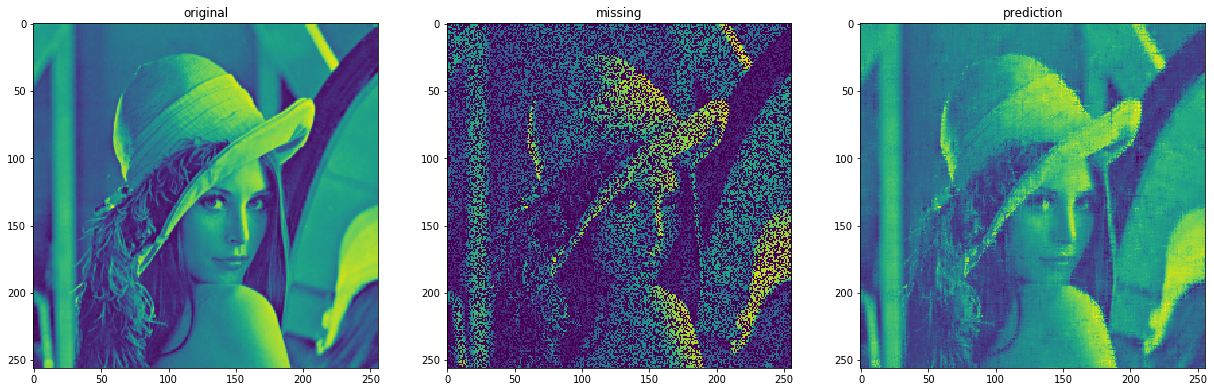

In [38]:
PlotLosses(all_losses)

with torch.no_grad():
    missing_matrix = missing_matrix.detach().numpy()
    pred_matrix = torch.mm(U, V.T) + U_b + V_b
    pred_matrix = pred_matrix.detach().detach().numpy()
    pred_matrix[complete_index] = missing_matrix[complete_index]


PlotImages(dense_mat, missing_matrix, pred_matrix)

Measurement(dense_mat, pred_matrix, missing_index)

## 2.2 方法二

### 2.2.1. 定义模型

In [40]:
class MF(torch.nn.Module):
    def __init__(self, M, N, K):
        super(MF, self).__init__()
        self.U   = torch.nn.Parameter(torch.randn(M, K))
        self.V   = torch.nn.Parameter(torch.randn(N, K))
        self.U_b = torch.nn.Parameter(torch.randn(M, 1))
        self.V_b = torch.nn.Parameter(torch.randn(1, N))

    def forward(self):
        out = torch.mm(self.U, self.V.T) + self.U_b + self.V_b
        return out

### 2.2.2. 训练过程

In [41]:
model = MF(M, N, K)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
all_losses = []
for epoch in range(1, epoches+1):
    
    pred_matrix = model()
    
    error = missing_matrix - pred_matrix
    
    loss    = torch.mean(error[complete_index] * error[complete_index])
    regular = beta / 2 + torch.norm(model.U, p='fro') + torch.norm(model.U_b, p='fro') \
                       + torch.norm(model.V, p='fro') + torch.norm(model.V_b, p='fro')
    
    all_loss = loss + regular
    
    all_losses.append([all_loss, loss, regular])
    
    optimizer.zero_grad()
    all_loss.backward()
    optimizer.step()
    
    if epoch % verbose == 0:
        print(epoch, loss.item())

50 1012.6622924804688
100 417.951904296875
150 281.09765625
200 218.37921142578125
250 187.1509552001953
300 172.4354705810547
350 166.75457763671875
400 164.17294311523438
450 162.7035369873047
500 161.76275634765625
550 161.12916564941406
600 160.67149353027344
650 160.32577514648438
700 160.04136657714844
750 159.81565856933594
800 159.6407012939453
850 159.5179901123047
900 159.42481994628906
950 159.36190795898438
1000 159.3133087158203


### 2.2.3. 结果评价

mae:12.6115, mse:345.2088


(12.611513, 345.20877)

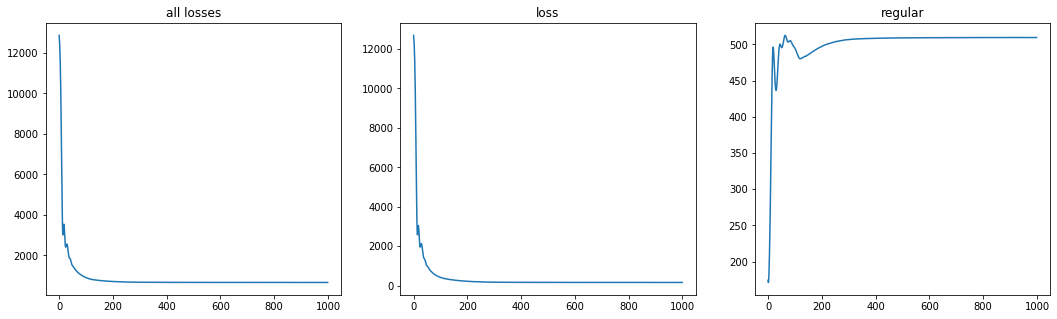

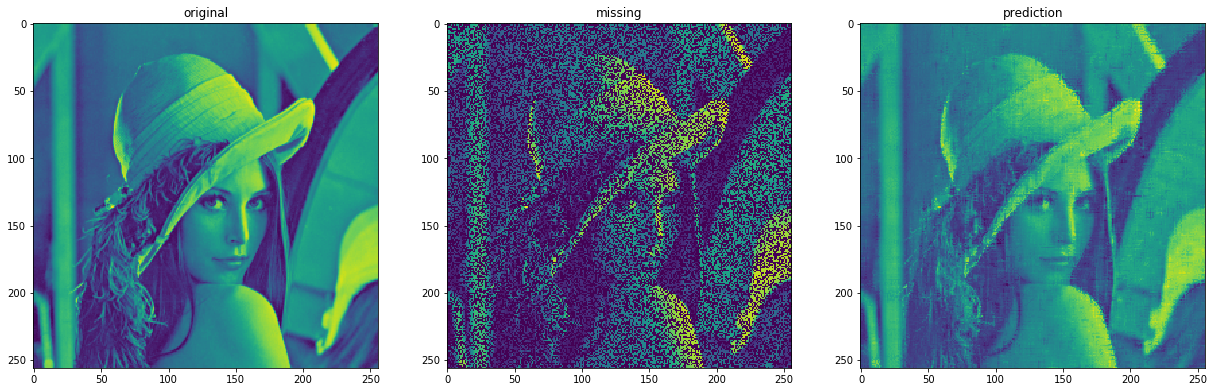

In [42]:
PlotLosses(all_losses)

with torch.no_grad():
    missing_matrix = missing_matrix.detach().numpy()
    pred_matrix = model()
    pred_matrix = pred_matrix.detach().detach().numpy()
    pred_matrix[complete_index] = missing_matrix[complete_index]

PlotImages(dense_mat, missing_matrix, pred_matrix)

Measurement(dense_mat, pred_matrix, missing_index)

# 3. Singular Value Thresholding Algorithm for Matrix Completion

## 3.1. 基本参数设置

In [11]:
rho           = 0.001
alpha         = 0.8
max_iter      = 100
missing_value = 0.

## 3.2. 模型

In [12]:
def LRMC(missing_matrix, alpha, rho, max_iter, missing_value=0):
    '''
    
    Parameters
    ----------
    missing_matrix : TYPE
        缺失值标记
    dense_mat : TYPE
        DESCRIPTION.
    alpha : TYPE
        DESCRIPTION.
    rho : TYPE
        DESCRIPTION.
    maxiter : TYPE
        DESCRIPTION.
    missing_value : TYPE, optional
        DESCRIPTION. The default is 0.

    Returns
    -------
    X : TYPE
        DESCRIPTION.

    '''
    
    # 未缺失值索引
    pos_train = np.where(missing_matrix != missing_value)
    # print(pos_train[0].shape)
    # 缺失值索引
    # pos_test  = np.where(missing_matrix == missing_value)
    
    # binary_matrix = missing_matrix.copy()
    # binary_matrix[pos_train] = 1
    
    X = missing_matrix.copy()
    Z = np.zeros_like(missing_matrix)
    T = np.zeros_like(missing_matrix)
    # error = np.zeros(maxiter)
    
    for it in range(max_iter):
        # start = time.time()
        u, s, v = np.linalg.svd(X + T / rho, full_matrices=False)
        # print('time:', time.time() - start)
        vec = s - alpha / rho
        vec[np.where(vec < 0)] = 0
        Z = np.matmul(np.matmul(u, np.diag(vec)), v)
        X = Z - T / rho
        # 未缺失值替换
        X[pos_train] = missing_matrix[pos_train]
        T = T - rho * (Z - X)
    #     rse[it] = (np.linalg.norm(X[pos_test] - dense_mat[pos_test], 2) 
    #                 / np.linalg.norm(dense_mat[pos_test], 2))
    return X
# ============================================================================

## 3.2. 结果评估

mae:23.5018, mse:1947.0517


(23.501757324014513, 1947.0516874013429)

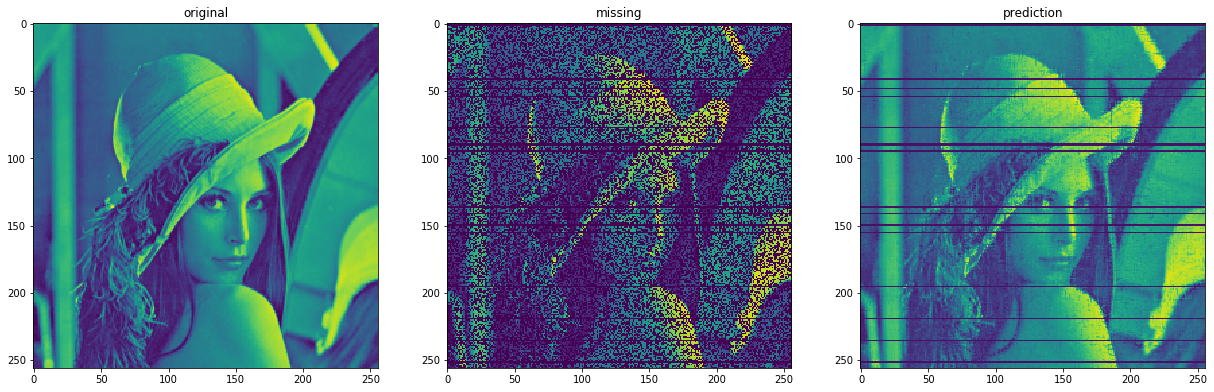

In [13]:
pred_matrix = LRMC(sparse_mat, alpha, rho, max_iter)
                   
PlotImages(dense_mat, missing_matrix, pred_matrix)

Measurement(dense_mat, pred_matrix, missing_index)              